# Beta Diversity

## What is beta diversity?

- Beta diversity is a distance or dissimilarity between two samples based on their composition

## Why do we care about beta diversity?

Beta diversity gives us ways to quantify how similar or dissimilar two samples are. We can then extrapolate this to comparing microbial communities across metadata variables. For example, are gut microbiome samples generally more similar to other gut microbiome samples or to oral microbiome samples?

## Quantifying beta diversity

### Beta diversity as a pairwise metric

Beta diversity is a **pairwise** metric, meaning each value exists for comparing a pair of samples. Each value is the distance (or dissimilarity) between the two samples.

For example, we can consider the pairwise distances between cities in the Colorado Front Range:

In [97]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [98]:


cities = ["Boulder", "Denver", "Golden", "Fort Collins", "Colorado Springs"]

# distances are given in miles
distances = np.array([[0, 24, 18, 39, 85],
                      [24, 0, 13, 56, 63],
                      [18, 13, 0, 56, 67],
                      [39, 56, 56, 0, 119],
                      [85, 63, 67, 119, 0]])

distances_df = pd.DataFrame(distances,
                            columns=cities,
                            index=cities)

print(distances_df)

                  Boulder  Denver  Golden  Fort Collins  Colorado Springs
Boulder                 0      24      18            39                85
Denver                 24       0      13            56                63
Golden                 18      13       0            56                67
Fort Collins           39      56      56             0               119
Colorado Springs       85      63      67           119                 0


In this case, because we have pairwise distances, we can't ask "What's the distance of Boulder?" Likewise, in a microbiome setting, we can't ask "What's the beta diversity of sample A?" Instead, we have to ask the question relative to another city/sample. For example, we can ask "What's the distance from Boulder to Fort Collins?" or "What's the the beta diversity between samples A and B?"

### Quantitative vs qualitative beta diversity metrics

Let's imagine we look at 10 people's shopping carts at the grocery store...

In [99]:
from scipy import sparse
from scipy.spatial.distance import pdist, squareform

In [102]:
foods = ["apples",
         "bananas",
         "broccoli",
         "spinach",
         "chicken",
         "beef",
         "milk",
         "orange juice",
         "apple juice",
         "cookies"
]

people = [f"Person {x}" for x in np.arange(1,11)]

# make some data
data = sparse.random(10,10, density=0.5, random_state=42)
# turn that data to integers from 1 to 10
data = round((data*10))

# make a dataframe where rows are people
# and columns are foods
data = pd.DataFrame(data.A,
                    columns=foods,
                    index=people)

#convert to integers
data = data.astype(int)

data

,apples,bananas,broccoli,spinach,chicken,beef,milk,orange juice,apple juice,cookies
Person 1,1,4,0,7,2,0,0,8,9,3
Person 2,0,7,0,7,0,0,0,0,3,0
Person 3,0,8,9,0,7,0,4,6,0,0
Person 4,0,9,0,6,0,7,0,7,2,2
Person 5,6,0,0,1,9,0,0,0,0,0
Person 6,9,4,1,9,6,2,7,0,6,2
Person 7,0,6,0,0,0,0,6,4,0,9
Person 8,5,0,4,0,1,0,0,10,0,0
Person 9,0,4,5,0,0,0,0,0,3,0
Person 10,5,9,0,7,3,0,1,0,0,0


In [107]:
def show_dist_mat(data, ids, metric):
    dist = squareform(pdist(data, metric))
    dist = pd.DataFrame(dist,
                        columns=people,
                        index=people)
    
    ax = sns.heatmap(dist)
    ax.set_title(f"{metric} distance")
    plt.show()

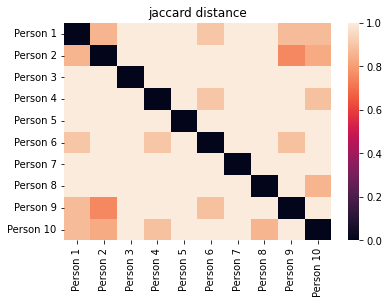

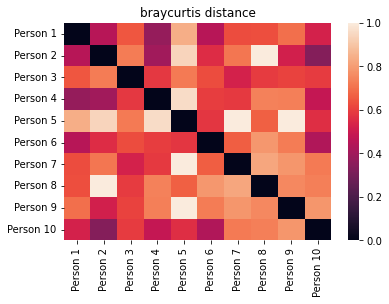

In [108]:
for metric in ["jaccard", "braycurtis"]:
    show_dist_mat(data, people, metric=metric)

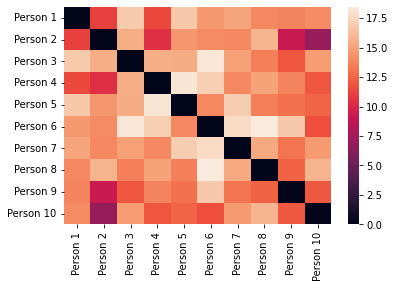

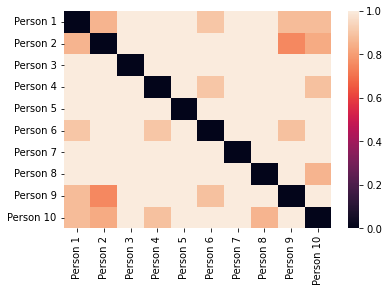

In [103]:
euclidean_dist = squareform(pdist(data))
euclidean_dist = pd.DataFrame(euclidean_dist,
                              columns=people,
                              index=people)
sns.heatmap(euclidean_dist)
plt.show()

jaccard_dist = squareform(pdist(data, metric="jaccard"))
jaccard_dist = pd.DataFrame(jaccard_dist,
                              columns=people,
                              index=people)
sns.heatmap(jaccard_dist)
plt.show()

### UniFrac

## Using beta diversity

<AxesSubplot:>

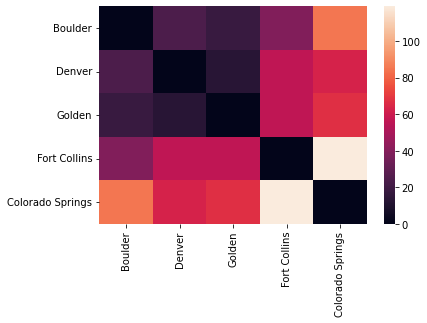

In [94]:
import seaborn as sns

sns.heatmap(distances_df)

## Real world example

## Interactive example/homework